In [1]:
import pandas as pd
import numpy as np
import scipy
from pykalman.pykalman import *
import control

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
from statannotations.Annotator import Annotator
import statsmodels.formula.api as smf

# Import custom modules
import prep_emotioncon 
import emotioncon_modelling
import emotioncon_stats
import auxiliary

In [2]:
# Create instances of the Modelling, Statistics, PrepEmotioncon, and Auxiliary classes
emo = emotioncon_modelling.Modelling() 
emostats = emotioncon_stats.Statistics() 
prep = prep_emotioncon.PrepEmotioncon()  
aux = auxiliary.Auxiliary()

attention_cr = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0])  # Define the attention check criteria as an array
mood_categories = ['disgusted', 'amused', 'calm', 'anxious', 'sad']  # Define the mood categories as a list
group_label = ['control', 'distancing'] # Define the group label as a list
filepath = '../'  # Specify the file path
savefig = False  # Flag to indicate whether to save figures or not

In [3]:
# Load the experiment data
data = np.load('../results/data_experiment.npy', allow_pickle=True)

# Process the loaded data into a DataFrame, mood ratings, and other related variables
df, mood_ratings, symptoms = prep.create_df_from_dict(data)

# Create an empty array to store split mood ratings
mood_ratings_split = np.empty((int(np.shape(mood_ratings)[0]/2), np.shape(mood_ratings)[1], \
                               np.shape(mood_ratings)[2], 2)) 
T = np.shape(mood_ratings[:,:,0])[0]  # Get the number of time points

# Split and store mood ratings based on time points
for t in range(2):
    mood_ratings_split[:,:,:,t] = mood_ratings[t*int(T/2):t*int(T/2) + int(T/2),:,:] 
    
Nsj = len(data) # number of subjects
print('number of subjects: ' + str(Nsj))

number of subjects: 108


In [4]:
# Check randomization
for i in range(2):
    for j in range(2):
        print('videoset = ' + str(i) + ', condition = ' + str(j), end=': ')
        print(round(np.sum((df['randomized_videoset']==i)&(df['randomized_condition']==j))/len(data),2))

# Number and Percentage of subjects allocated to distancing        
print('allocated to distancing: ' + str(df['randomized_condition'].sum()) \
      + '(' + str(round(df['randomized_condition'].mean(),2)) + '%)')

videoset = 0, condition = 0: 0.29
videoset = 0, condition = 1: 0.27
videoset = 1, condition = 0: 0.19
videoset = 1, condition = 1: 0.26
allocated to distancing: 57.0(0.53%)


mean: [True, True, False, False, False]
variance: [False, False, False, False, False]


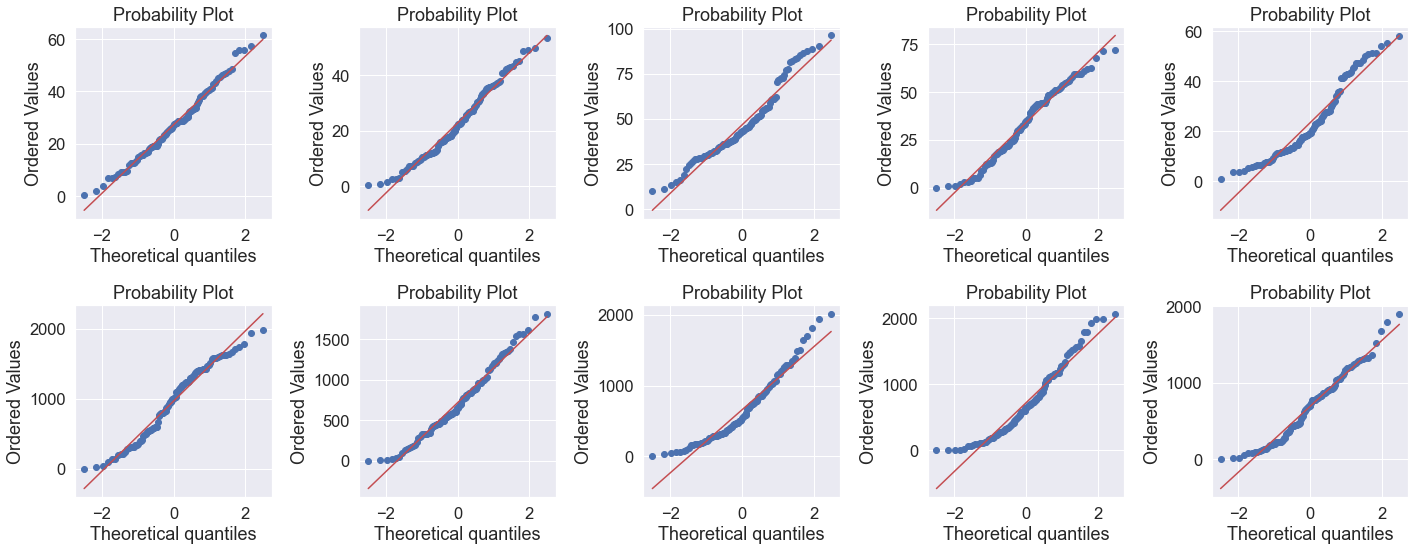

In [5]:
# Test normality of mean and variance of ratings
print('mean: ' + str(emostats.test_normality(np.nanmean(mood_ratings_split[1:,:,:,0],axis=0))))
print('variance: ' + str(emostats.test_normality(np.nanvar(mood_ratings_split[1:,:,:,0],axis=0))))

# Create subplots for probability plots
fig,axs = plt.subplots(2,5,figsize=(20,8))

# Plot probability plots for mean and variance of each mood category
for j in range(5):
    # Probability plot for mean
    scipy.stats.probplot(np.nanmean(mood_ratings_split[1:,j,:,0],axis=0), plot=axs[0,j])
    # Probability plot for variance
    scipy.stats.probplot(np.nanvar(mood_ratings_split[1:,j,:,0],axis=0), plot=axs[1,j])
plt.tight_layout()

Effect of Distancing on mean and variance of emotion ratings
--

In [6]:
# Summary stats of emotion ratings separted into group, and before and after the intervention

# Iterate over the intervention groups
for i in range(2):
    print(group_label[i] +' group:')
    mm = []
    T = np.shape(mood_ratings[:,:,0])[0]
    
    # Iterate over before and after intervention
    for t in range(2):
        # Calculate the mean of mood ratings
        mm.append(np.nanmean(mood_ratings_split[:,:,(df['randomized_condition']==i), t],axis=(0,2)))
        
        # Calculate the standard deviation of mood ratings
        mm.append(np.nanmean(np.nanstd(mood_ratings_split[:,:,(df['randomized_condition']==i), t],axis=0),axis=1))
    
    # Display the average ratings table for the current intervention group
    display(pd.DataFrame(mm, columns=mood_categories, \
                             index=['mean before', 'std before', 'mean after', 'std after']).T.round(2))


control group:


,mean before,std before,mean after,std after
disgusted,27.07,31.47,29.21,30.15
amused,24.79,27.17,22.00,24.83
calm,46.83,24.47,46.50,21.47
anxious,33.55,26.20,36.14,24.20
sad,22.40,26.29,25.33,26.42


distancing group:


,mean before,std before,mean after,std after
disgusted,26.63,27.85,15.90,18.64
amused,21.01,23.49,15.41,16.09
calm,47.23,23.89,57.95,15.77
anxious,33.81,22.92,20.61,15.10
sad,23.99,23.09,14.97,15.13


,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,6.53,1.26,0.288,10.05,1.93,0.095
after intervention,24.48,4.71,< 0.001,36.53,7.03,< 0.001
change (after - before),52.66,10.14,< 0.001,19.90,3.83,0.003


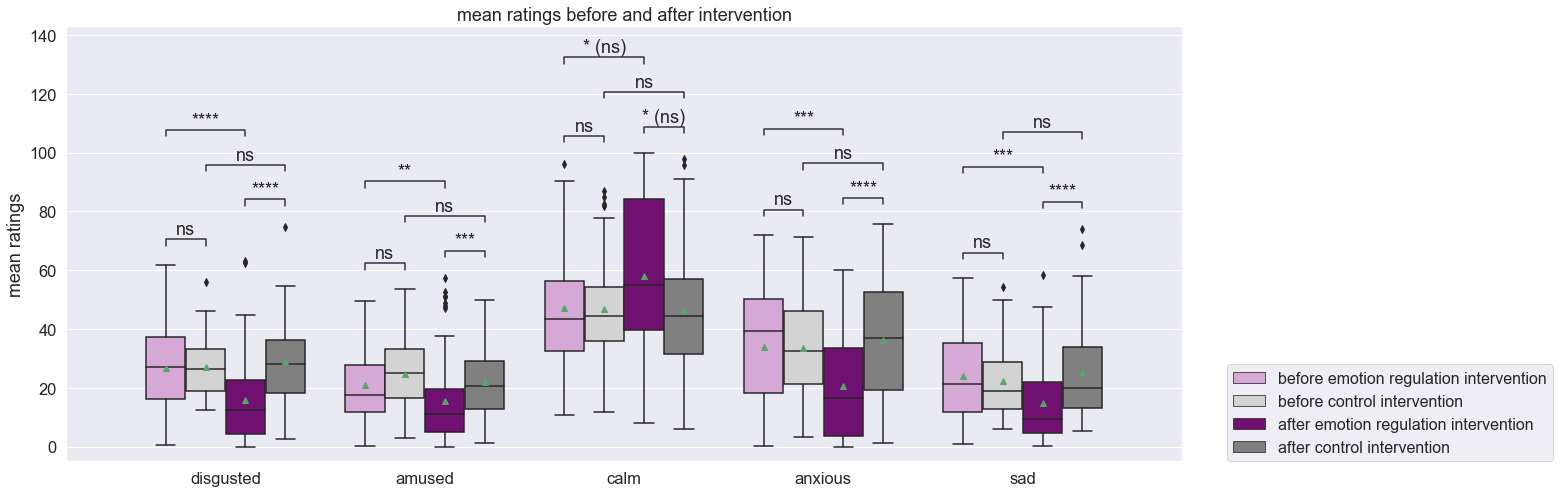

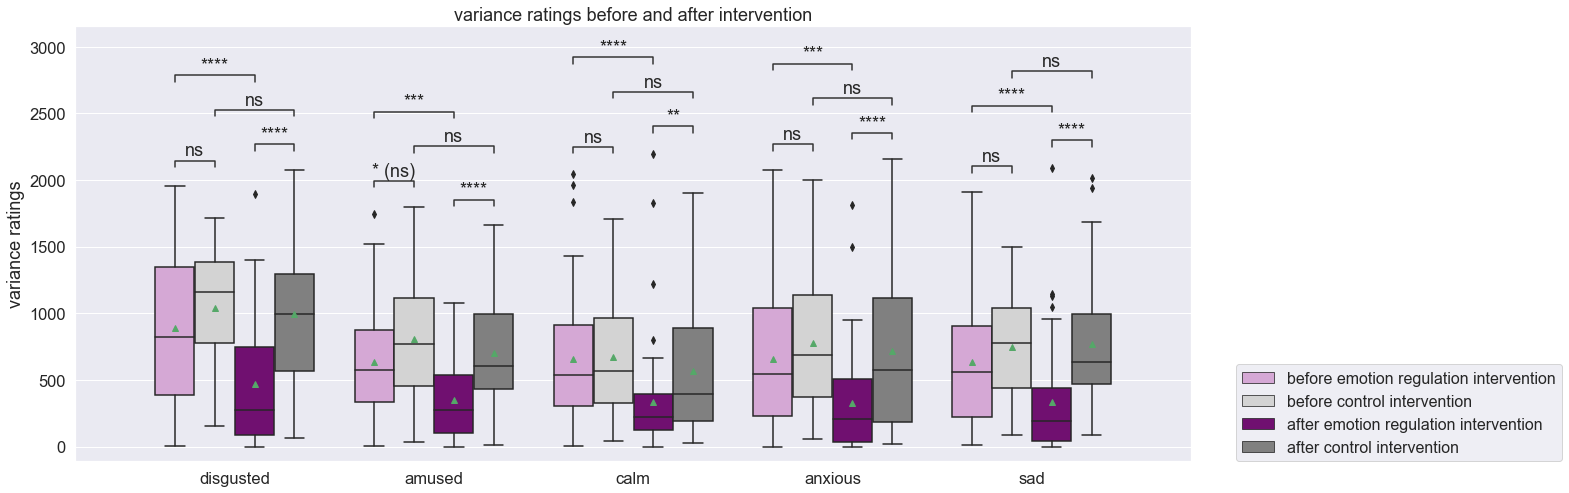

In [7]:
# Define the labels for the plots
plot_label = ['mean', 'variance']

# Define pairs of categories for comparison
pairs = []
for t in range(2):
    for i in mood_categories:
        pairs.append([(i, 0+t), (i, 2+t)])
        pairs.append([(i, t+(t*1)), (i, t+(t*1)+1)])

# Create an empty DataFrame to store the statistical results
df_stats_both = pd.DataFrame()

# Iterate over mean and variance of mood ratings
for j, i in enumerate([np.nanmean(mood_ratings_split,axis=0), np.nanvar(mood_ratings_split,axis=0)]):

    # Calculate the statistical differences between groups
    df_stats, pvalues, tvalues = emostats.stats_group_difference(i, df)

    # Create a DataFrame for plotting
    df_plot = emostats.make_df(i, df, mood_categories)

    # Create the plot for group differences
    fig, ax = plt.subplots(figsize=(20,8))
    fig, ax = emostats.plot_group_difference(df=df_plot, data_labels=mood_categories, \
                                             data_name=plot_label[j] + ' ratings', pairs=pairs, fig=fig, ax=ax)
    ax.set(ylabel=plot_label[j] + ' ratings')

    # Append the statistical results to the overall DataFrame
    df_stats_both = pd.concat((df_stats_both, df_stats), axis=1)

# Display the statistical results table
display(df_stats_both)

In [8]:
# Print the significance level for multiple comparisons
alpha_adjusted = np.round(0.05 / 5, 3)
print('Adjusted significance level: p≤' + str(alpha_adjusted))

# Create an empty DataFrame to store the statistical results
df_stats = pd.DataFrame()

# Iterate over mean and variance of mood ratings
for j in [np.nanmean(mood_ratings_split, axis=0), np.nanvar(mood_ratings_split, axis=0)]:
    pval, statistics = [np.empty((4, 5)) for _ in range(2)]
    mm1, mm2 = [np.empty((4, 5), dtype=object) for _ in range(2)]
    
    # Group comparisons using Mann-Whitney U-test
    for t in range(2):
        for i in range(5):
            dd = j[i, :, t]
            statistics[t, i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition'] == 0],
                                                       dd[df['randomized_condition'] == 1]).statistic
            pval[t, i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition'] == 0],
                                                 dd[df['randomized_condition'] == 1]).pvalue
            mm1[t, i] = str(int(np.round(np.nanmean(dd[df['randomized_condition'] == 0])))) + '$\pm$' + \
                        str(int(np.round(np.nanstd(dd[df['randomized_condition'] == 0]))))
            mm2[t, i] = str(int(np.round(np.nanmean(dd[df['randomized_condition'] == 1])))) + '$\pm$' + \
                        str(int(np.round(np.nanstd(dd[df['randomized_condition'] == 1]))))
    
    # Before vs after comparisons within each group using Wilcoxon test
    for g in range(2):
        for i in range(5):
            dd = j[i, :, :]
            statistics[g + 2, i] = scipy.stats.wilcoxon(dd[df['randomized_condition'] == g, 0],
                                                       dd[df['randomized_condition'] == g, 1]).statistic
            pval[g + 2, i] = scipy.stats.wilcoxon(dd[df['randomized_condition'] == g, 0],
                                                 dd[df['randomized_condition'] == g, 1]).pvalue
            mm1[g + 2, i] = str(int(np.round(np.nanmean(dd[df['randomized_condition'] == g, 0])))) + '$\pm$' + \
                            str(int(np.round(np.nanstd(dd[df['randomized_condition'] == g, 0]))))
            mm2[g + 2, i] = str(int(np.round(np.nanmean(dd[df['randomized_condition'] == g, 1])))) + '$\pm$' + \
                            str(int(np.round(np.nanstd(dd[df['randomized_condition'] == g, 1]))))
    
    # Prepare the statistical results array for each comparison
    statsarray = np.empty((4, 20), dtype=object)
    for i in range(4):
        for j in range(5):
            statsarray[i, j * 4] = mm1[i, j]
            statsarray[i, j * 4 + 1] = mm2[i, j]
            statsarray[i, j * 4 + 2] = np.round(statistics[i, j], 2)
            if pval[i, j] < 0.001:
                statsarray[i, j * 4 + 3] = '$<0.001$'
            else:
                statsarray[i, j * 4 + 3] = np.round(pval[i, j], 3)
    
    # Create a header for the DataFrame
    header = [np.repeat(mood_categories, 4), len(mood_categories) * ['v1 (M$\pm$SD)', 'v2 (M$\pm$SD)', \
                                                                     'statistics', 'pvalue']]
    
    # Concatenate the statistical results into the DataFrame
    df_stats = pd.concat((df_stats, pd.DataFrame(statsarray, index=['group comparison at t=0', 'group comparison t=1',
                            'before vs after g=0', 'before vs after g=1'], columns=header)))

# Set the index of the DataFrame
df_stats.index = [np.repeat(['mean', 'variance'], 4), df_stats.index]

# Display the statistical results
display(df_stats.round(2))

Adjusted significance level: p≤0.01


disgusted                           \
                                 v1 (M$\pm$SD) v2 (M$\pm$SD) statistics   
mean     group comparison at t=0     27$\pm$10     27$\pm$15     1514.5   
         group comparison t=1        29$\pm$14     16$\pm$15     2219.0   
         before vs after g=0         27$\pm$10     29$\pm$14      525.5   
         before vs after g=1         27$\pm$15     16$\pm$15      152.0   
variance group comparison at t=0  1041$\pm$409   888$\pm$549     1705.0   
         group comparison t=1      992$\pm$517   472$\pm$451     2255.0   
         before vs after g=0      1041$\pm$409   992$\pm$517      616.0   
         before vs after g=1       888$\pm$549   472$\pm$451      147.0   

                                                  amused                \
                                    pvalue v1 (M$\pm$SD) v2 (M$\pm$SD)   
mean     group comparison at t=0      0.71     25$\pm$11     21$\pm$13   
         group comparison t=1     $<0.001$     22$\pm$13     15$\pm$16   
         before vs after g=0         0.197     25$\pm$11     22$\pm$13   
         before vs after g=1      $<0.001$     21$\pm$13     15$\pm$16   
variance group comparison at t=0     0.122   804$\pm$422   633$\pm$399   
         group comparison t=1     $<0.001$   703$\pm$434   349$\pm$317   
         before vs after g=0          0.66   804$\pm$422   703$\pm$434   
         before vs after g=1      $<0.001$   633$\pm$399   349$\pm$317   

                                                               calm  \
                                 statistics    pvalue v1 (M$\pm$SD)   
mean     group comparison at t=0     1738.5      0.08     47$\pm$18   
         group comparison t=1        1997.0  $<0.001$     46$\pm$22   
         before vs after g=0          273.0  $<0.001$     47$\pm$18   
         before vs after g=1          308.0  $<0.001$     47$\pm$20   
variance group comparison at t=0     1787.0      0.04   673$\pm$435   
         group comparison t=1        2164.0  $<0.001$   564$\pm$478   
         before vs after g=0          345.0     0.003   673$\pm$435   
         before vs after g=1          246.0  $<0.001$   660$\pm$475   

                                                                     \
                                 v2 (M$\pm$SD) statistics    pvalue   
mean     group comparison at t=0     47$\pm$20     1497.0     0.791   
         group comparison t=1        58$\pm$26     1083.5     0.023   
         before vs after g=0         46$\pm$22      560.5     0.337   
         before vs after g=1         58$\pm$26      279.0  $<0.001$   
variance group comparison at t=0   660$\pm$475     1502.0     0.768   
         group comparison t=1      331$\pm$395     1924.0     0.004   
         before vs after g=0       564$\pm$478      323.0     0.001   
         before vs after g=1       331$\pm$395      133.0  $<0.001$   

                                       anxious                           \
                                 v1 (M$\pm$SD) v2 (M$\pm$SD) statistics   
mean     group comparison at t=0     34$\pm$16     34$\pm$20     1422.0   
         group comparison t=1        36$\pm$20     21$\pm$18     2091.0   
         before vs after g=0         34$\pm$16     36$\pm$20      471.0   
         before vs after g=1         34$\pm$20     21$\pm$18       68.0   
variance group comparison at t=0   778$\pm$511   654$\pm$529     1682.0   
         group comparison t=1      715$\pm$569   330$\pm$377     2098.0   
         before vs after g=0       778$\pm$511   715$\pm$569      566.0   
         before vs after g=1       654$\pm$529   330$\pm$377      187.0   

                                                     sad                \
                                    pvalue v1 (M$\pm$SD) v2 (M$\pm$SD)   
mean     group comparison at t=0     0.849     22$\pm$12     24$\pm$16   
         group comparison t=1     $<0.001$     25$\pm$16     15$\pm$14   
         before vs after g=0         0.072     22$\pm$12     25$\pm$16   
  

In [9]:
# Perform MANOVA for mean and variance of mood ratings
from statsmodels.multivariate.manova import MANOVA

for j, i in enumerate([np.nanmean(mood_ratings_split, axis=0), np.nanvar(mood_ratings_split, axis=0)]):
    print(['mean', 'variance'][j])
    df_manova = pd.DataFrame()

    # Concatenate the data for before and after time points
    for t in range(2):
        df_manova = pd.concat((df_manova, pd.DataFrame(i[:, :, t])), axis=1, ignore_index=True)

    df_manova = df_manova.T
    df_manova.columns = mood_categories
    df_manova['time'] = np.concatenate((np.zeros([108, 1]), np.ones([108, 1])))
    df_manova['condition'] = np.concatenate((df['randomized_condition'].values, df['randomized_condition'].values))

    # Perform MANOVA using the formula 'disgusted + amused + calm + anxious + sad ~ condition*time'
    fit = MANOVA.from_formula('disgusted + amused + calm + anxious + sad ~ condition*time', data=df_manova)

    # Display the summary of the MANOVA results
    display(fit.mv_test().summary_frame)

mean


Value Num DF Den DF     F Value  \
Effect         Statistic                                                    
Intercept      Wilks' lambda           0.188486      5  208.0  179.105491   
               Pillai's trace          0.811514    5.0  208.0  179.105491   
               Hotelling-Lawley trace   4.30542      5  208.0  179.105491   
               Roy's greatest root      4.30542      5    208  179.105491   
condition      Wilks' lambda           0.975054      5  208.0    1.064301   
               Pillai's trace          0.024946    5.0  208.0    1.064301   
               Hotelling-Lawley trace  0.025584      5  208.0    1.064301   
               Roy's greatest root     0.025584      5    208    1.064301   
time           Wilks' lambda           0.977691      5  208.0    0.949219   
               Pillai's trace          0.022309    5.0  208.0    0.949219   
               Hotelling-Lawley trace  0.022818      5  208.0    0.949219   
               Roy's greatest root     0.022818      5    208    0.949219   
condition:time Wilks' lambda           0.941113      5  208.0    2.602998   
               Pillai's trace          0.058887    5.0  208.0    2.602998   
               Hotelling-Lawley trace  0.062572      5  208.0    2.602998   
               Roy's greatest root     0.062572      5    208    2.602998   

                                         Pr > F  
Effect         Statistic                         
Intercept      Wilks' lambda                0.0  
               Pillai's trace               0.0  
               Hotelling-Lawley trace       0.0  
               Roy's greatest root          0.0  
condition      Wilks' lambda           0.381261  
               Pillai's trace          0.381261  
               Hotelling-Lawley trace  0.381261  
               Roy's greatest root     0.381261  
time           Wilks' lambda           0.450169  
               Pillai's trace          0.450169  
               Hotelling-Lawley trace  0.450169  
               Roy's greatest root     0.450169  
condition:time Wilks' lambda           0.026208  
               Pillai's trace          0.026208  
               Hotelling-Lawley trace  0.026208  
               Roy's greatest root     0.026208

variance


Value Num DF Den DF    F Value  \
Effect         Statistic                                                   
Intercept      Wilks' lambda           0.415844      5  208.0  58.437553   
               Pillai's trace          0.584156    5.0  208.0  58.437553   
               Hotelling-Lawley trace  1.404749      5  208.0  58.437553   
               Roy's greatest root     1.404749      5    208  58.437553   
condition      Wilks' lambda           0.960274      5  208.0   1.720959   
               Pillai's trace          0.039726    5.0  208.0   1.720959   
               Hotelling-Lawley trace  0.041369      5  208.0   1.720959   
               Roy's greatest root     0.041369      5    208   1.720959   
time           Wilks' lambda           0.970623      5  208.0    1.25907   
               Pillai's trace          0.029377    5.0  208.0    1.25907   
               Hotelling-Lawley trace  0.030266      5  208.0    1.25907   
               Roy's greatest root     0.030266      5    208    1.25907   
condition:time Wilks' lambda           0.960255      5  208.0   1.721829   
               Pillai's trace          0.039745    5.0  208.0   1.721829   
               Hotelling-Lawley trace   0.04139      5  208.0   1.721829   
               Roy's greatest root      0.04139      5    208   1.721829   

                                         Pr > F  
Effect         Statistic                         
Intercept      Wilks' lambda                0.0  
               Pillai's trace               0.0  
               Hotelling-Lawley trace       0.0  
               Roy's greatest root          0.0  
condition      Wilks' lambda           0.131124  
               Pillai's trace          0.131124  
               Hotelling-Lawley trace  0.131124  
               Roy's greatest root     0.131124  
time           Wilks' lambda           0.282971  
               Pillai's trace          0.282971  
               Hotelling-Lawley trace  0.282971  
               Roy's greatest root     0.282971  
condition:time Wilks' lambda           0.130926  
               Pillai's trace          0.130926  
               Hotelling-Lawley trace  0.130926  
               Roy's greatest root     0.130926

Demand effect? Difference in slider time.
--

In [10]:
# Calculate mean reaction time for each subject before and after intervention
rt = np.empty((len(data), 2))

for i in range(len(data)):
    for t in range(2):
        rt[i, t] = np.nanmean(data[i]['slider_rt'][t * int(T/2):int(T/2) + t * int(T/2)])

# Calculate the difference in reaction times between before and after intervention
df['diff_rt'] = rt[:, 1] - rt[:, 0]

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,randomized_condition,2175115.49,1,106,2175115.49,0.15,0.70,0.00,NaN
1,time,25842827.70,1,106,25842827.70,24.84,0.00,0.19,1.0
2,Interaction,6723063.08,1,106,6723063.08,6.46,0.01,0.06,NaN


control group: Ttest_relResult(statistic=5.870594435013308, pvalue=3.4754824710167726e-07)
distancing group: Ttest_relResult(statistic=1.7302488315029068, pvalue=0.08909384627355069)
Ttest_indResult(statistic=2.542046432368639, pvalue=0.012466292700886937)


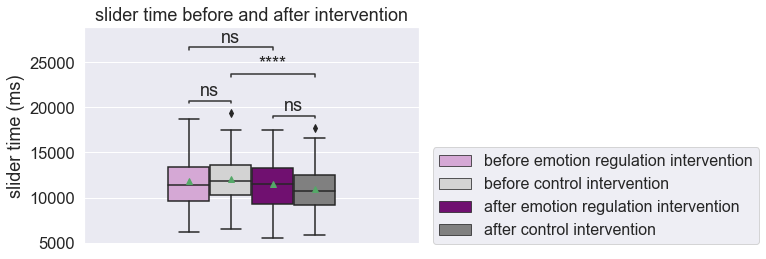

In [11]:
import pingouin as pg

# Reshape the data for mixed ANOVA
df_melt = pd.melt(pd.concat((df, pd.DataFrame(rt, columns=['rt_before', 'rt_after'])), axis=1).reset_index(),
                  id_vars=list(df.columns) + ['index'], value_name='rt', var_name='time')

# Perform mixed ANOVA
mixed_anova = pg.mixed_anova(data=df_melt, dv='rt', within='time', subject='index', between='randomized_condition')
display(pd.DataFrame(mixed_anova).round(2))

# Post-hoc t-tests
for i in range(2):
    print(['control', 'distancing'][i] + ' group', end=': ')
    print(scipy.stats.ttest_rel(rt[df['randomized_condition']==i,0], rt[df['randomized_condition']==i,1]))

fig, axs = plt.subplots(figsize=(6, 4))
df_plot = emostats.make_df(rt, df, ['rt'])
pairs = []
for t in range(2):
    i = 'rt'
    pairs.append([(i, 0+t), (i, 2+t)])
    pairs.append([(i, t+(t*1)), (i, t+(t*1)+1)])

# Plot group differences using t-test_ind
pvalues = []
for i in range(2):
    foo, p = scipy.stats.ttest_ind(rt[df['randomized_condition']==0,i], \
                                  rt[df['randomized_condition']==1,i])
    pvalues.append(p)
    foo, p = scipy.stats.ttest_rel(rt[df['randomized_condition']==i,0], \
                                   rt[df['randomized_condition']==i,1])
    pvalues.append(p)
emostats.plot_group_difference(df=df_plot, data_labels=['rt'], data_name='slider time',
                               pairs=pairs, pvalues=pvalues, ax=axs, fig=fig)
axs.set(ylabel='slider time (ms)', xticks=[])

# Perform independent t-test and plot boxplot of delta slider time
print(scipy.stats.ttest_ind(df['diff_rt'][df['randomized_condition']==1], \
                            df['diff_rt'][df['randomized_condition']==0]))

----
Psychopathological Questionnaires
--

In [12]:
# The questionnaires dictionary stores the column indices corresponding to each questionnaire
questionnaires = {'phq': range(0, 10), 'gad': range(10, 10 + 7), 'ders': range(17, 17 + 18)}

# List of labels for the questionnaires used in the plots
questionnaire_label = ['PHQ-9', 'GAD-7', 'DERS-18']

# Loop through each questionnaire and calculate the total score for each participant
# Store the total scores and their corresponding z-scores in the DataFrame 'df'
for i in questionnaires.items():
    # Calculate the total score for the current questionnaire by summing the columns for each participant
    df[i[0]] = np.sum(symptoms[:, i[1]], axis=1)
    
    # Calculate the z-scores for the total scores of the current questionnaire
    df[i[0] + '_zscore'] = prep.zscore(df[i[0]])

# Save the DataFrame 'df' containing the questionnaire data to a CSV file in the '../results/' directory
df.to_csv('../results/questionnaire_data.csv')

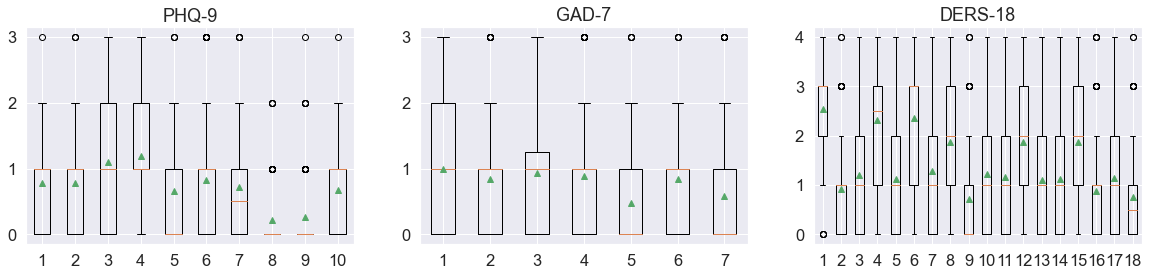

In [13]:
# Create a figure with three subplots (one for each questionnaire)
fi, ax = plt.subplots(1, 3, figsize=(20, 4))

for j, i in enumerate(questionnaires.items()):
    
    # Plot a boxplot for the current questionnaire's data
    ax[j].boxplot(symptoms[:, i[1]], showmeans=True)
    ax[j].set_title(questionnaire_label[j])

In [14]:
# Correlation between questionnaires
display(df[questionnaires.keys()].corr())

,phq,gad,ders
phq,1.000000,0.753185,0.690018
gad,0.753185,1.000000,0.732192
ders,0.690018,0.732192,1.000000


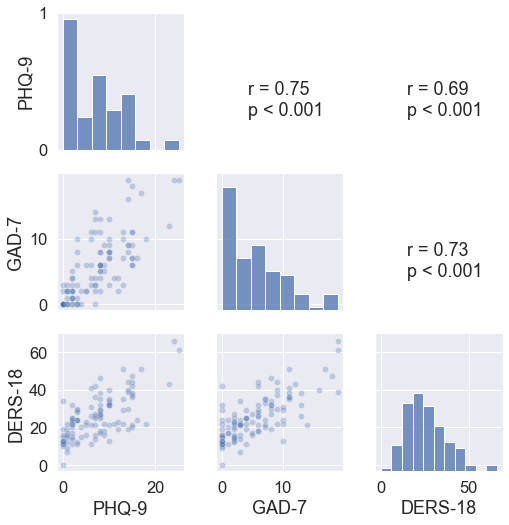

In [15]:
# Function to calculate and display correlation coefficients and p-values on the plot.
def reg_coef(x, y, label=None, color=None, hue=None, **kwargs):
    ax = plt.gca()
    # Calculate the Pearson correlation coefficient (r) and the corresponding p-value (p).
    r, p = scipy.stats.pearsonr(x, y)
    # Format the p-value for display on the plot.
    if p < 0.001:
        p = '< 0.001'
    else:
        p = '= ' + str(np.round(p, 2))
    # Annotate the plot with the calculated correlation coefficient (r) and p-value (p).
    ax.annotate('r = ' + str(np.round(r, 2)) + '\np ' + p, xy=(0.25, 0.25), xycoords='axes fraction', ha='left')
    ax.set_axis_off()

# Create a PairGrid plot for the data from the DataFrame 'df' using the specified questionnaires as columns.
# 'hue=None' means no additional grouping is done based on a specific variable.
g = sns.PairGrid(df[questionnaires.keys()], hue=None)

# Map the 'reg_coef' function to the upper triangle of the PairGrid.
g.map_upper(aux.reg_coef)

# Map a histogram to the diagonal of the PairGrid.
g.map_diag(sns.histplot)

# Map a scatter plot with alpha transparency of 0.3 to the lower triangle of the PairGrid.
g.map_lower(sns.scatterplot, alpha=0.3)

# Initialize variables 'k' and 'j' to control labeling of y-axis and x-axis, respectively.
k, j = 0, 0

# Loop through all the subplots (axes) in the PairGrid.
for i, ax in enumerate(g.axes.flat):
    # Set y-axis tick labels for the first subplot (top-left).
    if i == 0: 
        ax.set_yticks([0, 1])
        ax.set_yticklabels([0, 1])
    # Set y-axis label for each questionnaire on the left-most subplots.
    if i in [0, 3, 6]: 
        ax.set_ylabel(questionnaire_label[k])
        k += 1
    # Set x-axis label for each questionnaire on the bottom-most subplots.
    if i > 5: 
        ax.set_xlabel(questionnaire_label[j])
        j += 1

# If 'savefig' is True, save the plot as an SVG file in the specified 'filepath' and 'results/figures/' directory.
if savefig:
    plt.savefig(filepath + 'results/figures/questionnaires.svg')

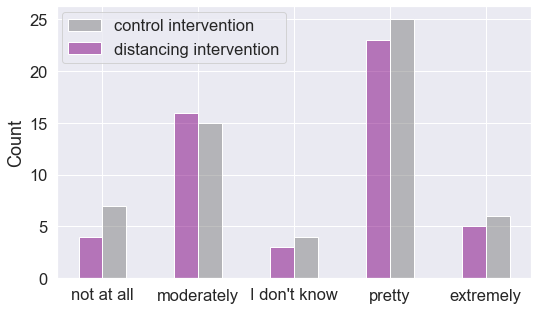

In [16]:
# Create a histogram showing how successful participants perceived their compliance with the intervention.
fig, axs = plt.subplots(figsize=(8.5, 5))

# Create a histogram using Seaborn's 'histplot' function.
b = sns.histplot(data=df, x='intervention_success', hue='randomized_condition', multiple="dodge", \
                 shrink=0.5, ax=axs, discrete=True, palette={0: "purple", 1: "grey"}, legend=False, alpha=0.5)
b.set(xlabel='', xticks=range(5), \
             xticklabels=['not at all', 'moderately', 'I don\'t know', 'pretty', 'extremely'])
b.legend(['control intervention', 'distancing intervention'], loc=(0.01, 0.79))

# If 'savefig' is True, save the plot as an SVG file in the specified 'filepath' and 'results/figures/' directory.
if savefig:
    plt.savefig(filepath + 'results/figures/intervention_success.svg')


In [17]:
# Calculate the Spearman correlation between 'DERS' and 'intervention_success'.
print(scipy.stats.spearmanr(df['ders'], df['intervention_success']))

# Display the summary table for the generalized linear model (GLM) between 'intervention_success' and 'ders'.
# The GLM is fitted using 'intervention_success' as the response and 'ders' as the predictor variable.
display(smf.glm('intervention_success ~ ders', df, missing='drop').fit().summary().tables[1])

# Fit a GLM between 'intervention_success' and 'ders', including interaction terms with 'randomized_condition'.
model = smf.glm('intervention_success ~ ders * randomized_condition', df, missing='drop').fit()

# Extract the coefficient summary table from the GLM results.
df_new = pd.DataFrame(model.summary().tables[1][1:], columns=model.summary().tables[1][0])
df_new = df_new.iloc[:, 1:]
df_new.index = ['Intercept', 'DERS-18', 'intervention', 'intervention * DERS-18']

# Display the coefficient summary table with the results of the GLM.
display(df_new)

SpearmanrResult(correlation=-0.2318134156516171, pvalue=0.015777453888499843)


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.8253,0.279,10.120,0.000,2.278,3.372
ders,-0.0262,0.010,-2.630,0.009,-0.046,-0.007


,coef,std err,z,P>|z|,[0.025,0.975]
Intercept,2.7566,0.398,6.924,0.000,1.976,3.537
DERS-18,-0.0225,0.014,-1.612,0.107,-0.050,0.005
intervention,0.1483,0.564,0.263,0.793,-0.957,1.254
intervention * DERS-18,-0.0078,0.020,-0.389,0.697,-0.047,0.032


the higher they score in DERS the lower they judged their intervention success,
however does not seem specific to emotion regulation intervention

----
Relation with symptoms
--

In [18]:
# Define the timing of mood ratings, representing different time points of the experiment.
# The 'mood_dict' dictionary stores mood ratings for different time points: baseline, before intervention, after intervention, mean change, variance before intervention, and variance after intervention.
# Each mood rating is transposed (T) to match the DataFrame structure.
mood_dict = {
    'baseline': mood_ratings[0, :, :].T,
    'mean_t1': np.nanmean(mood_ratings_split[1:, :, :, 0], axis=0).T,
    'mean_t2': np.nanmean(mood_ratings_split[1:, :, :, 1], axis=0).T,
    'mean_change': np.nanmean(mood_ratings_split[:, :, :,1], axis=0).T -
                   np.nanmean(mood_ratings_split[:, :, :,0], axis=0).T,
    'var_t1': np.nanvar(mood_ratings_split[:, :, :,0], axis=0).T,
    'var_t2': np.nanvar(mood_ratings_split[:, :, :,1], axis=0).T,
    'var_change': np.nanvar(mood_ratings_split[:, :, :,1], axis=0).T -
                   np.nanvar(mood_ratings_split[:, :, :,0], axis=0).T,
}

df_mood = df.copy()
# Iterate through each entry in the 'mood_dict' dictionary.
for j in mood_dict.items():
    # Create mood-related column names with the timing label (e.g., 'baseline', 'mean_t1', etc.).
    mood_columns = [i + '_' + j[0] for i in mood_categories]
    
    # Create a temporary DataFrame with mood ratings for the specific timing.
    tmp = pd.DataFrame(j[1], columns=mood_columns)
    
    # Concatenate the temporary DataFrame with 'df_mood'.
    df_mood = pd.concat((df_mood, tmp), axis=1)
    
    # Z-score normalize each mood-related column in 'df_mood' to make the data comparable and standardized.
    for i in mood_columns:
        df_mood[i] = prep.zscore(df_mood[i])


In [19]:
# Define different formula options for the generalized linear model (GLM).
# The 'formula' list contains two sub-lists, each representing a different formula for the GLM.
# The first sub-list represents a simple formula (no interaction terms), and the second sub-list represents a formula with interaction terms involving group.
formula = [
    [' ~ ', [1]],  # Simple formula without interaction
    [' ~ randomized_condition + ', [2]],  # Formula involving 'randomized_condition'
    [' ~ randomized_condition * ', [3]]  # Formula with interaction involving 'randomized_condition'
]

# Define the indices of specific statistical items (coefficients) to extract from the GLM results.
stats_items = [0, 3, 4, 5]

# Initialize an empty list to store DataFrames containing GLM statistics for each questionnaire.
df_stats_all = []
adjusted_alpha = 0.05/(5*3*3) # adjusting for 3 questionnaires, 5 emotion items, 3 time points (before, after & change)
# Iterate through each questionnaire (PHQ, GAD, and DERS).
for q in [i + '_zscore' for i in questionnaires.keys()]:
    # Create an empty DataFrame 'df_stats' to store the GLM statistics for the current questionnaire.
    df_stats = pd.DataFrame()
    
    # Iterate through each mood category.
    for m in mood_categories:
        glmstats, idx = [], []
        # Find mood-related column names in 'df_mood' that match the current mood category.
        mood_columns = [i for i in df_mood.columns if m in i]
        
        # Iterate through the mood-related columns for the current mood category.
        for d, k in enumerate(mood_columns):
            
            if 'baseline' in k or 't1' in k: formula_variable_specific = [formula[0]]
            else: formula_variable_specific = formula[1:]
            
            for glm_formula in formula_variable_specific:
                
                # Fit the GLM using the current mood-related column as the response variable and the questionnaire (q) as the predictor variable.
                model = smf.glm(k + glm_formula[0] + q, df_mood, missing='drop').fit()

                # Extract the specified statistical items (coefficients) from the GLM results and store them in 'glmstats'.
                for g in glm_formula[1]:
                    tmp = prep.convert_stats_table(model, g)
                    glmstats.append([tmp.values[i] for i in stats_items])
                    idx.append(tmp.name + ' -> ' + list(mood_dict.keys())[d])

        # Create appropriate column names and concatenate the GLM statistics for the current mood category to 'df_stats'.
        statscolumns = [tmp.index[i] for i in stats_items]
        header = [np.repeat(np.array(m), 4),
                  np.array(statscolumns)]
        df_stats = pd.concat((df_stats, pd.DataFrame(glmstats, columns=header, index=idx)), axis=1)
    
    # Replace p-values less than 0.001 with the string '<0.001'.
    idx = []
    for m in mood_categories:
        idx.append(df_stats[(m, 'P>|z|')] < adjusted_alpha)
    df_stats = df_stats.round(3)
    for i, m in enumerate(mood_categories):
        df_stats.loc[idx[i], (m, 'P>|z|')] = '$<' + str(np.round(adjusted_alpha,3)) + '$'
    
    # Display the DataFrame 'df_stats' with the GLM statistics for the current questionnaire.
    display(df_stats)
    
    # Append the DataFrame 'df_stats' to the list 'df_stats_all'.
    df_stats_all.append(df_stats)
    
    # Uncomment the line below to export the DataFrame 'df_stats' as a LaTeX table.
    print(df_stats.to_latex(escape=False))


disgusted                   \
                                                    coef     P>|z| [0.025   
phq_zscore -> baseline                             0.312  $<0.001$  0.131   
phq_zscore -> mean_t1                              0.311  $<0.001$  0.130   
phq_zscore -> mean_t2                              0.184     0.035  0.013   
randomized_condition:phq_zscore -> mean_t2         0.117     0.508 -0.229   
phq_zscore -> mean_change                         -0.083     0.332 -0.251   
randomized_condition:phq_zscore -> mean_change    -0.054     0.754 -0.395   
phq_zscore -> var_t1                              -0.086     0.373 -0.276   
phq_zscore -> var_t2                               0.033     0.698 -0.135   
randomized_condition:phq_zscore -> var_t2          0.054     0.756 -0.288   
phq_zscore -> var_change                           0.112     0.218 -0.066   
randomized_condition:phq_zscore -> var_change      0.104     0.571 -0.255   

                                                      amused                \
                                               0.975]   coef  P>|z| [0.025   
phq_zscore -> baseline                          0.493  0.056  0.566 -0.134   
phq_zscore -> mean_t1                           0.492  0.106  0.272 -0.083   
phq_zscore -> mean_t2                           0.354  0.074  0.434 -0.112   
randomized_condition:phq_zscore -> mean_t2      0.462  0.150  0.435 -0.227   
phq_zscore -> mean_change                       0.085 -0.044  0.652 -0.232   
randomized_condition:phq_zscore -> mean_change  0.286 -0.128  0.513 -0.510   
phq_zscore -> var_t1                            0.103 -0.149  0.122 -0.337   
phq_zscore -> var_t2                            0.202  0.066  0.456 -0.107   
randomized_condition:phq_zscore -> var_t2       0.397  0.268  0.132 -0.080   
phq_zscore -> var_change                        0.289  0.244  0.008  0.065   
randomized_condition:phq_zscore -> var_change   0.463  0.122  0.509 -0.241   

                                                        calm                   \
                                               0.975]   coef     P>|z| [0.025   
phq_zscore -> baseline                          0.246 -0.467  $<0.001$ -0.635   
phq_zscore -> mean_t1                           0.295 -0.184     0.054 -0.371   
phq_zscore -> mean_t2                           0.260 -0.276     0.002 -0.455   
randomized_condition:phq_zscore -> mean_t2      0.527 -0.180     0.328 -0.542   
phq_zscore -> mean_change                       0.145 -0.214     0.017 -0.389   
randomized_condition:phq_zscore -> mean_change  0.255 -0.214     0.234 -0.568   
phq_zscore -> var_t1                            0.040 -0.263     0.005 -0.447   
phq_zscore -> var_t2                            0.239 -0.066     0.481 -0.251   
randomized_condition:phq_zscore -> var_t2       0.615 -0.052     0.787 -0.427   
phq_zscore -> var_change                        0.422  0.259     0.004  0.084   
randomized_condition:phq_zscore -> var_change   0.485 -0.038     0.835 -0.393   

                                                      anxious            \
                                               0.975]    coef     P>|z|   
phq_zscore -> baseline                         -0.298   0.521  $<0.001$   
phq_zscore -> mean_t1                           0.003   0.336  $<0.001$   
phq_zscore -> mean_t2                          -0.098   0.253     0.004   
randomized_condition:phq_zscore -> mean_t2      0.181   0.198      0.26   
phq_zscore -> mean_change                      -0.039  -0.062      0.45   
randomized_condition:phq_zscore -> mean_change  0.139   0.170     0.305   
phq_zscore -> var_t1                           -0.080  -0.141     0.144   
phq_zscore -> var_t2                            0.118  -0.068     0.452   
randomized_condition:phq_zscore -> var_t2       0.324   0.241     0.187   
phq_zscore -> var_change                        0.434   0.083     0.368   
randomized_condition:phq_zscore -> var_change   0.318   0.079     0.674   



\begin{tabular}{lrlrrrlrrrlrrrlrrrlrr}
\toprule
{} & \multicolumn{4}{l}{disgusted} & \multicolumn{4}{l}{amused} & \multicolumn{4}{l}{calm} & \multicolumn{4}{l}{anxious} & \multicolumn{4}{l}{sad} \\
{} &      coef &     P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] &   coef &     P>|z| & [0.025 & 0.975] &    coef &     P>|z| & [0.025 & 0.975] &   coef &     P>|z| & [0.025 & 0.975] \\
\midrule
phq_zscore -> baseline                         &     0.312 &  $<0.001$ &  0.131 &  0.493 &  0.056 &  0.566 & -0.134 &  0.246 & -0.467 &  $<0.001$ & -0.635 & -0.298 &   0.521 &  $<0.001$ &  0.358 &  0.683 &  0.456 &  $<0.001$ &  0.287 &  0.626 \\
phq_zscore -> mean_t1                          &     0.311 &  $<0.001$ &  0.130 &  0.492 &  0.106 &  0.272 & -0.083 &  0.295 & -0.184 &     0.054 & -0.371 &  0.003 &   0.336 &  $<0.001$ &  0.157 &  0.515 &  0.357 &  $<0.001$ &  0.179 &  0.535 \\
phq_zscore -> mean_t2                          &     0.184 &     0.035 &  0.013 &  0.354 &  0.074 &

disgusted                       \
                                                    coef  P>|z| [0.025 0.975]   
gad_zscore -> baseline                             0.117  0.224 -0.072  0.306   
gad_zscore -> mean_t1                              0.288  0.002  0.105  0.470   
gad_zscore -> mean_t2                              0.112  0.201 -0.060  0.285   
randomized_condition:gad_zscore -> mean_t2         0.315   0.07 -0.026  0.657   
gad_zscore -> mean_change                         -0.140  0.098 -0.306  0.026   
randomized_condition:gad_zscore -> mean_change    -0.032   0.85 -0.366  0.302   
gad_zscore -> var_t1                               0.105  0.276 -0.084  0.294   
gad_zscore -> var_t2                               0.082  0.338 -0.086  0.250   
randomized_condition:gad_zscore -> var_t2          0.141  0.413 -0.196  0.477   
gad_zscore -> var_change                          -0.007  0.936 -0.185  0.171   
randomized_condition:gad_zscore -> var_change     -0.046    0.8 -0.405  0.312   

                                               amused                       \
                                                 coef  P>|z| [0.025 0.975]   
gad_zscore -> baseline                         -0.006  0.951 -0.196  0.184   
gad_zscore -> mean_t1                           0.048  0.623 -0.142  0.238   
gad_zscore -> mean_t2                          -0.007  0.941 -0.194  0.179   
randomized_condition:gad_zscore -> mean_t2      0.123  0.519 -0.251  0.497   
gad_zscore -> mean_change                      -0.071  0.463 -0.259  0.118   
randomized_condition:gad_zscore -> mean_change -0.214  0.264 -0.591  0.162   
gad_zscore -> var_t1                           -0.040  0.678 -0.231  0.150   
gad_zscore -> var_t2                            0.062  0.482 -0.111  0.235   
randomized_condition:gad_zscore -> var_t2       0.250  0.154 -0.094  0.595   
gad_zscore -> var_change                        0.135  0.149 -0.048  0.317   
randomized_condition:gad_zscore -> var_change  -0.044  0.816 -0.411  0.324   

                                                 calm                          \
                                                 coef     P>|z| [0.025 0.975]   
gad_zscore -> baseline                         -0.405  $<0.001$ -0.579 -0.231   
gad_zscore -> mean_t1                          -0.301  $<0.001$ -0.483 -0.120   
gad_zscore -> mean_t2                          -0.214     0.021 -0.396 -0.032   
randomized_condition:gad_zscore -> mean_t2     -0.082     0.661 -0.447  0.283   
gad_zscore -> mean_change                       0.019     0.836 -0.161  0.198   
randomized_condition:gad_zscore -> mean_change  0.027     0.882 -0.334  0.388   
gad_zscore -> var_t1                           -0.122     0.206 -0.311  0.067   
gad_zscore -> var_t2                           -0.028     0.767 -0.213  0.157   
randomized_condition:gad_zscore -> var_t2      -0.104     0.583 -0.475  0.267   
gad_zscore -> var_change                        0.125     0.175 -0.056  0.305   
randomized_condition:gad_zscore -> var_change  -0.234     0.202 -0.593  0.126   

                                               anxious                   \
                                                  coef     P>|z| [0.025   
gad_zscore -> baseline                           0.561  $<0.001$  0.403   
gad_zscore -> mean_t1                            0.447  $<0.001$  0.277   
gad_zscore -> mean_t2                            0.292  $<0.001$  0.124   
randomized_condition:gad_zscore -> mean_t2       0.230     0.178 -0.105   
gad_zscore -> mean_change                       -0.145     0.072 -0.303   
randomized_condition:gad_zscore -> mean_change  -0.024     0.885 -0.341   
gad_zscore -> var_t1                             0.025     0.794 -0.165   
gad_zscore -> var_t2                            -0.010     0.911 -0.188   
randomized_condition:gad_zscore -> var_t2        0.310     0.085 -0.042   
gad_zscore -> var_change                        -0.038     0.683 -0.220   
randomized_condition:gad

\begin{tabular}{lrlrrrlrrrlrrrlrrrlrr}
\toprule
{} & \multicolumn{4}{l}{disgusted} & \multicolumn{4}{l}{amused} & \multicolumn{4}{l}{calm} & \multicolumn{4}{l}{anxious} & \multicolumn{4}{l}{sad} \\
{} &      coef &  P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] &   coef &     P>|z| & [0.025 & 0.975] &    coef &     P>|z| & [0.025 & 0.975] &   coef &     P>|z| & [0.025 & 0.975] \\
\midrule
gad_zscore -> baseline                         &     0.117 &  0.224 & -0.072 &  0.306 & -0.006 &  0.951 & -0.196 &  0.184 & -0.405 &  $<0.001$ & -0.579 & -0.231 &   0.561 &  $<0.001$ &  0.403 &  0.718 &  0.349 &  $<0.001$ &  0.170 &  0.527 \\
gad_zscore -> mean_t1                          &     0.288 &  0.002 &  0.105 &  0.470 &  0.048 &  0.623 & -0.142 &  0.238 & -0.301 &  $<0.001$ & -0.483 & -0.120 &   0.447 &  $<0.001$ &  0.277 &  0.618 &  0.325 &  $<0.001$ &  0.145 &  0.505 \\
gad_zscore -> mean_t2                          &     0.112 &  0.201 & -0.060 &  0.285 & -0.007 &  0.941 & -0

disgusted                   \
                                                     coef     P>|z| [0.025   
ders_zscore -> baseline                             0.203     0.033  0.016   
ders_zscore -> mean_t1                              0.379  $<0.001$  0.203   
ders_zscore -> mean_t2                              0.232     0.007  0.065   
randomized_condition:ders_zscore -> mean_t2         0.288     0.089 -0.044   
ders_zscore -> mean_change                         -0.086     0.316 -0.253   
randomized_condition:ders_zscore -> mean_change    -0.016     0.927 -0.352   
ders_zscore -> var_t1                               0.130     0.178 -0.059   
ders_zscore -> var_t2                               0.120     0.158 -0.047   
randomized_condition:ders_zscore -> var_t2          0.175     0.304 -0.159   
ders_zscore -> var_change                           0.007     0.936 -0.171   
randomized_condition:ders_zscore -> var_change     -0.102     0.575 -0.460   

                                                       amused                \
                                                0.975]   coef  P>|z| [0.025   
ders_zscore -> baseline                          0.389 -0.015  0.877 -0.205   
ders_zscore -> mean_t1                           0.555  0.060  0.535 -0.130   
ders_zscore -> mean_t2                           0.400  0.050  0.598 -0.136   
randomized_condition:ders_zscore -> mean_t2      0.621  0.236  0.214 -0.136   
ders_zscore -> mean_change                       0.082  0.006  0.954 -0.183   
randomized_condition:ders_zscore -> mean_change  0.321 -0.007  0.973 -0.386   
ders_zscore -> var_t1                            0.319  0.013  0.897 -0.178   
ders_zscore -> var_t2                            0.287  0.113  0.196 -0.059   
randomized_condition:ders_zscore -> var_t2       0.509  0.305   0.08 -0.036   
ders_zscore -> var_change                        0.185  0.127  0.172 -0.055   
randomized_condition:ders_zscore -> var_change   0.255 -0.017  0.928 -0.385   

                                                         calm            \
                                                0.975]   coef     P>|z|   
ders_zscore -> baseline                          0.175 -0.387  $<0.001$   
ders_zscore -> mean_t1                           0.250 -0.396  $<0.001$   
ders_zscore -> mean_t2                           0.236 -0.315  $<0.001$   
randomized_condition:ders_zscore -> mean_t2      0.607 -0.215      0.23   
ders_zscore -> mean_change                       0.194 -0.030     0.747   
randomized_condition:ders_zscore -> mean_change  0.373 -0.008     0.963   
ders_zscore -> var_t1                            0.203 -0.079     0.412   
ders_zscore -> var_t2                            0.285 -0.064     0.497   
randomized_condition:ders_zscore -> var_t2       0.645  0.021     0.912   
ders_zscore -> var_change                        0.310  0.022     0.814   
randomized_condition:ders_zscore -> var_change   0.351 -0.258     0.162   

                                                              anxious  \
                                                [0.025 0.975]    coef   
ders_zscore -> baseline                         -0.563 -0.212   0.481   
ders_zscore -> mean_t1                          -0.570 -0.221   0.458   
ders_zscore -> mean_t2                          -0.491 -0.139   0.305   
randomized_condition:ders_zscore -> mean_t2     -0.567  0.136   0.257   
ders_zscore -> mean_change                      -0.209  0.150  -0.136   
randomized_condition:ders_zscore -> mean_change -0.369  0.352  -0.000   
ders_zscore -> var_t1                           -0.269  0.110   0.074   
ders_zscore -> var_t2                           -0.248  0.121   0.008   
randomized_condition:ders_zscore -> var_t2      -0.350  0.392   0.316   
ders_zscore -> var_change                       -0.160  0.203  -0.080   
randomized_condition:ders_zscore -> var_change  -0.620  0.104  -0.077   

                                                                         \
    

\begin{tabular}{lrlrrrlrrrlrrrlrrrlrr}
\toprule
{} & \multicolumn{4}{l}{disgusted} & \multicolumn{4}{l}{amused} & \multicolumn{4}{l}{calm} & \multicolumn{4}{l}{anxious} & \multicolumn{4}{l}{sad} \\
{} &      coef &     P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] &   coef &     P>|z| & [0.025 & 0.975] &    coef &     P>|z| & [0.025 & 0.975] &   coef &     P>|z| & [0.025 & 0.975] \\
\midrule
ders_zscore -> baseline                         &     0.203 &     0.033 &  0.016 &  0.389 & -0.015 &  0.877 & -0.205 &  0.175 & -0.387 &  $<0.001$ & -0.563 & -0.212 &   0.481 &  $<0.001$ &  0.314 &  0.648 &  0.408 &  $<0.001$ &  0.234 &  0.582 \\
ders_zscore -> mean_t1                          &     0.379 &  $<0.001$ &  0.203 &  0.555 &  0.060 &  0.535 & -0.130 &  0.250 & -0.396 &  $<0.001$ & -0.570 & -0.221 &   0.458 &  $<0.001$ &  0.288 &  0.627 &  0.388 &  $<0.001$ &  0.213 &  0.563 \\
ders_zscore -> mean_t2                          &     0.232 &     0.007 &  0.065 &  0.400 &  0.05

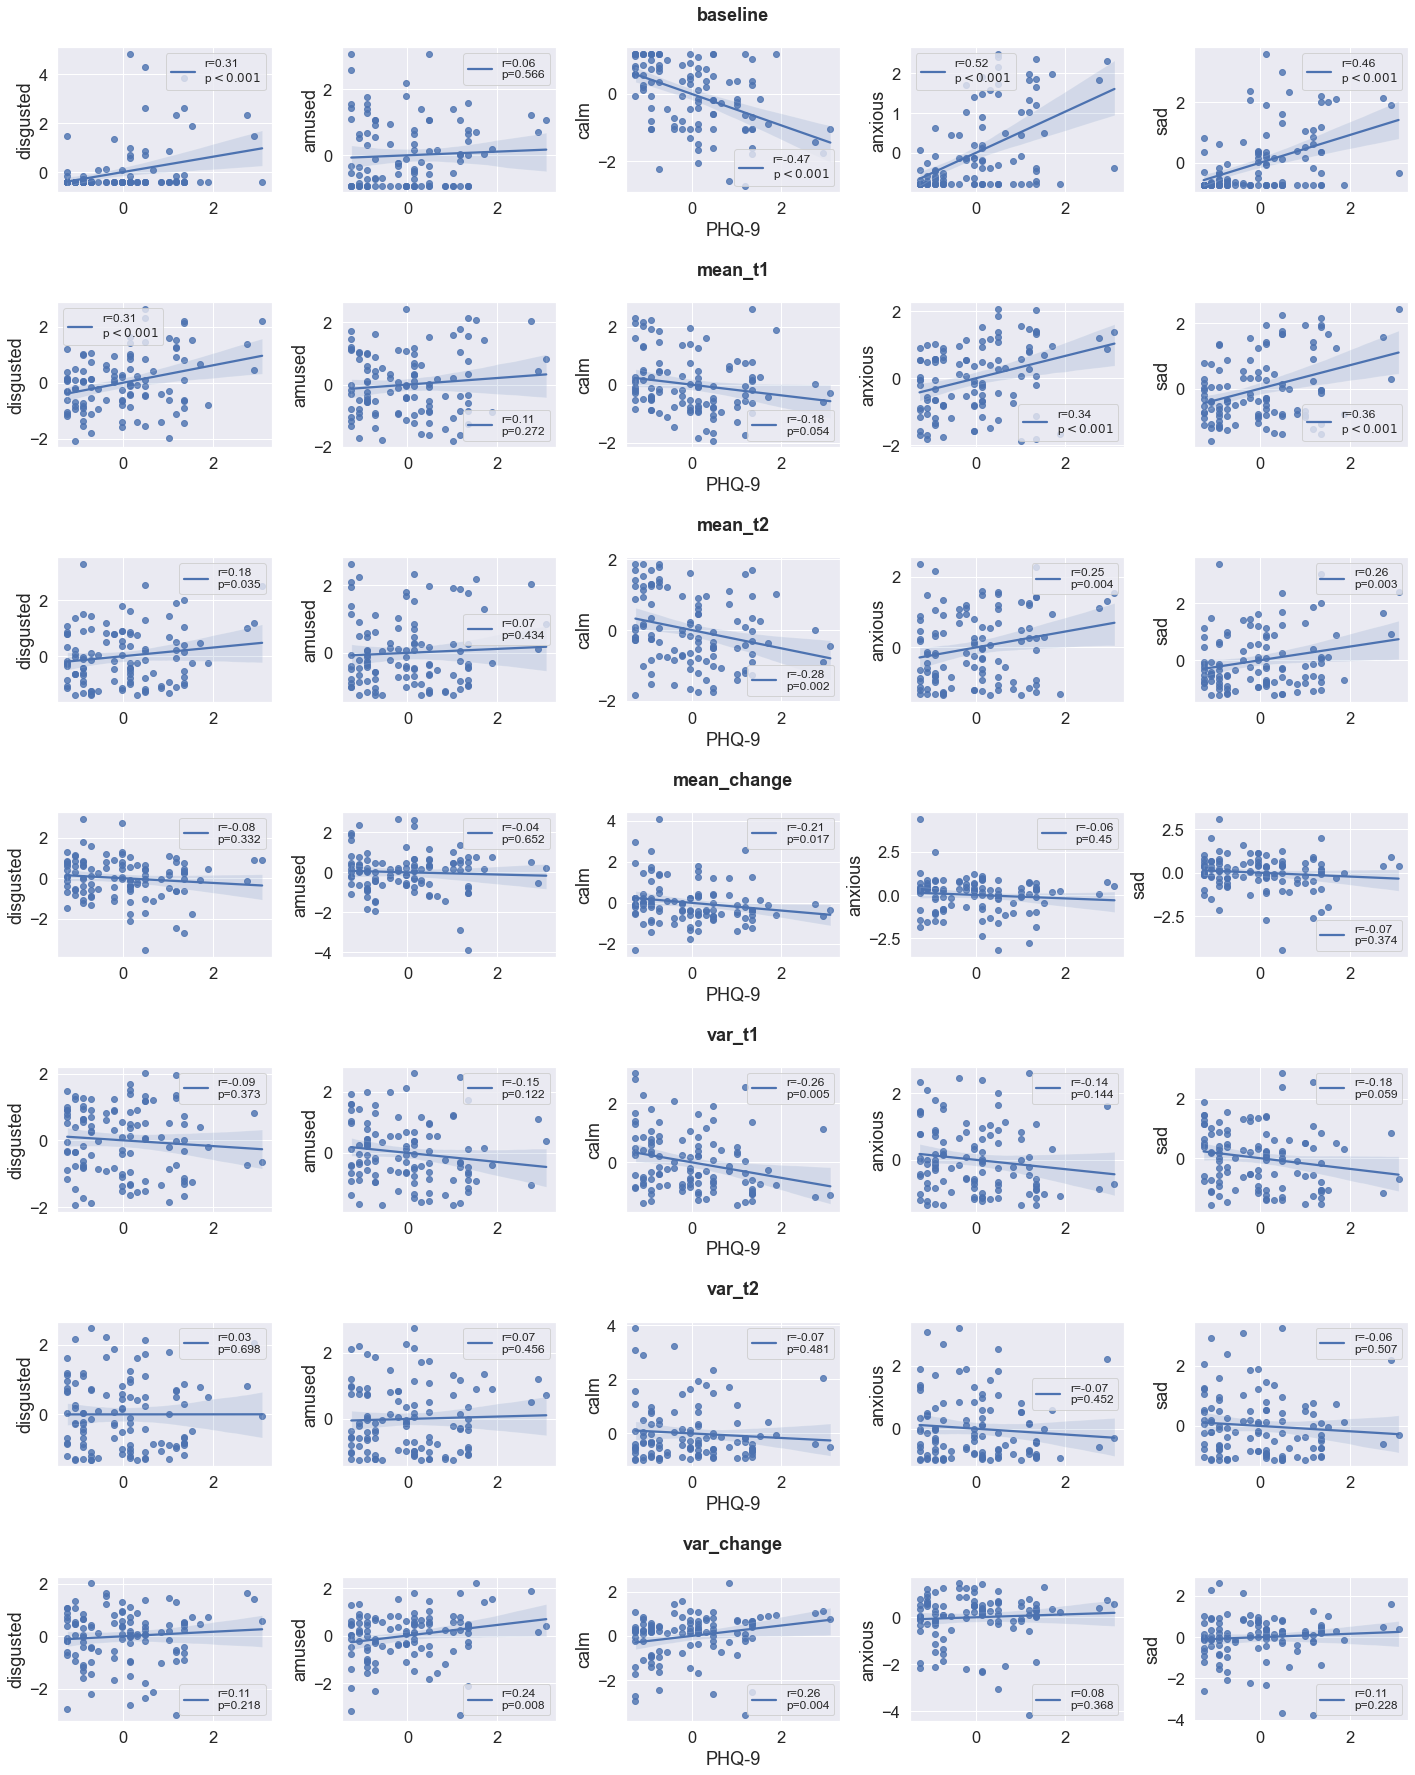

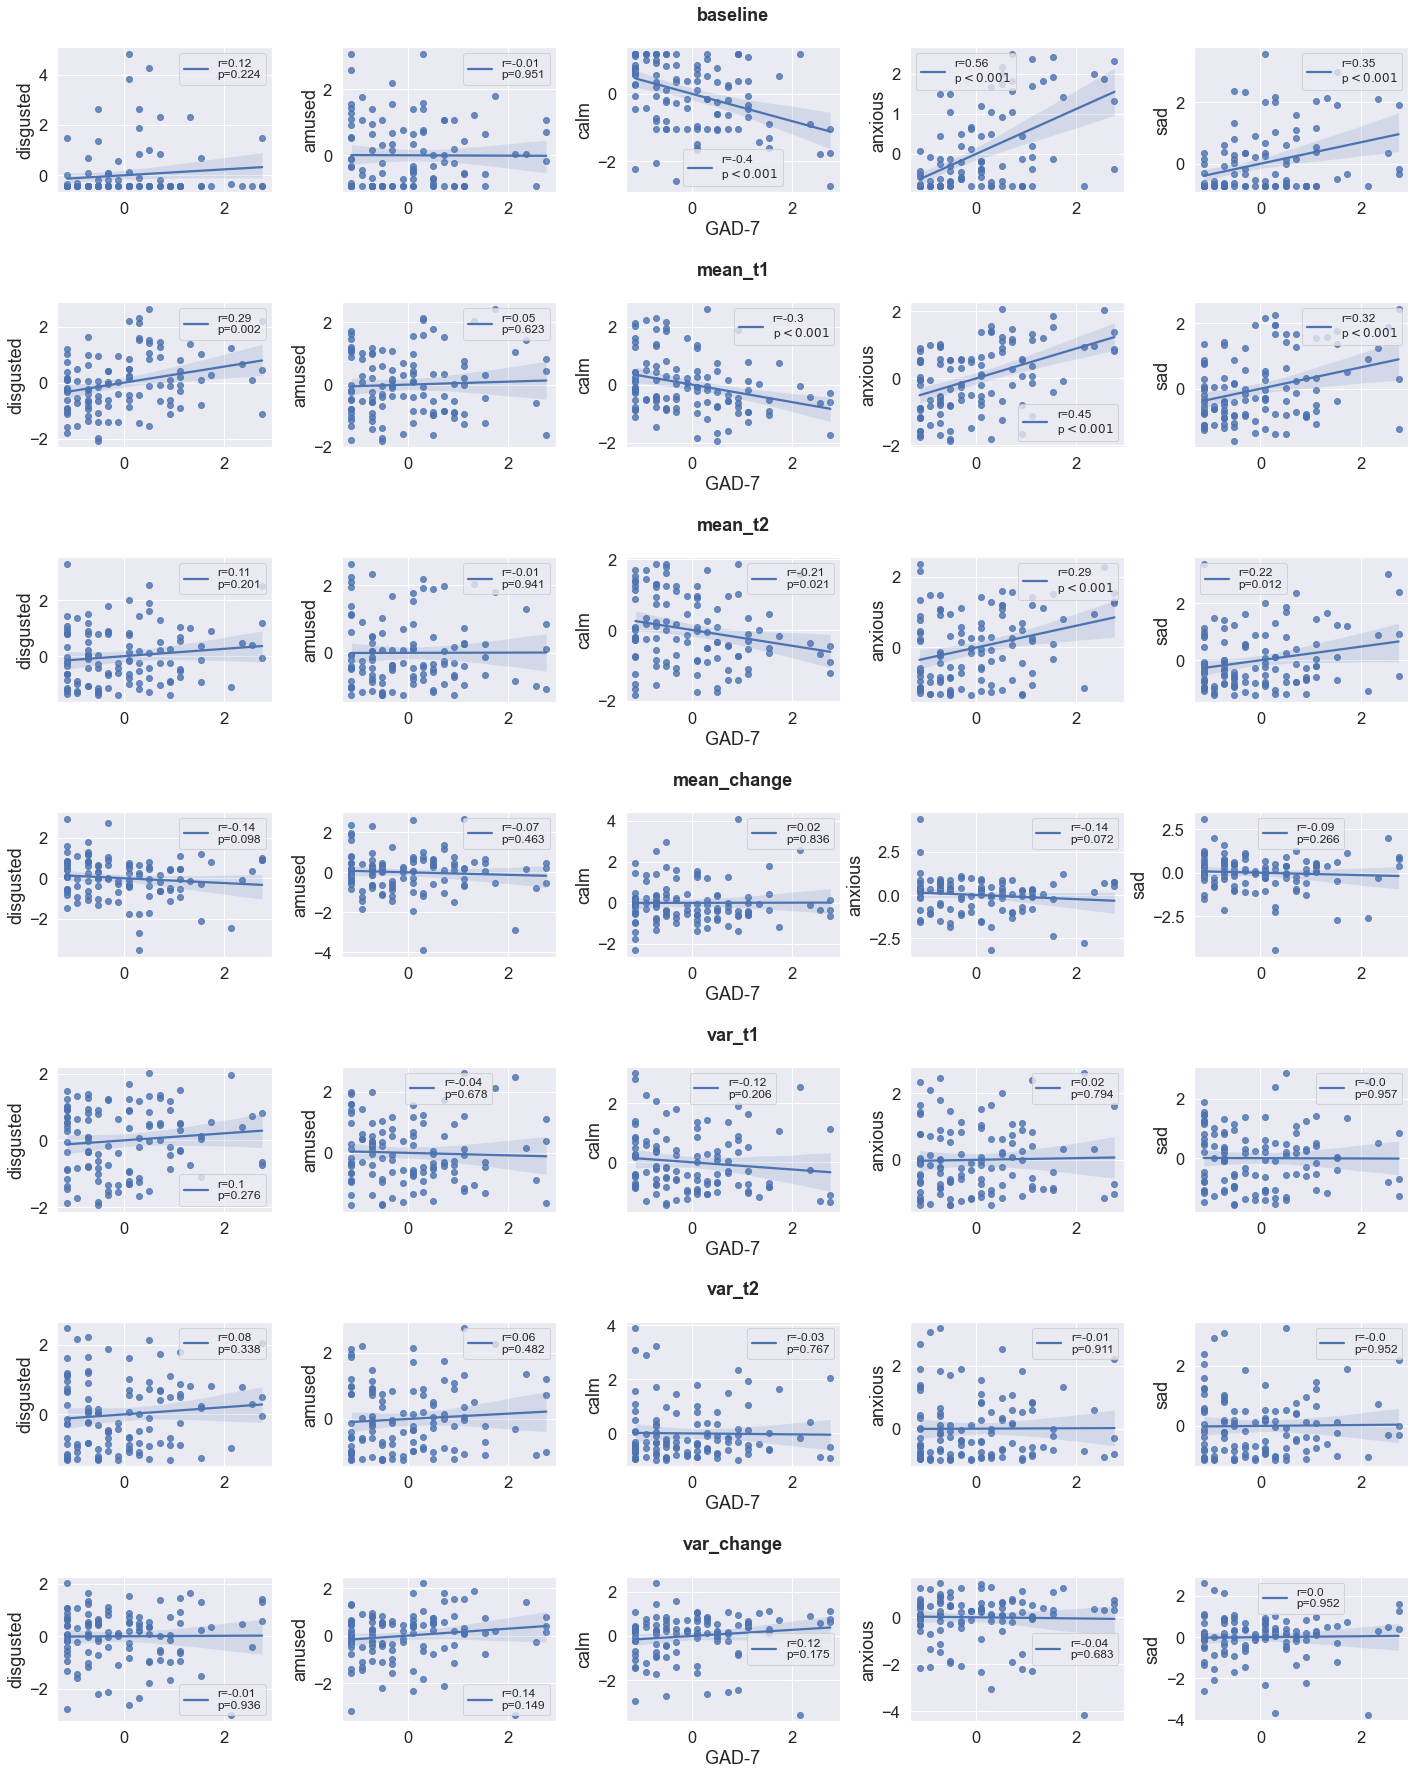

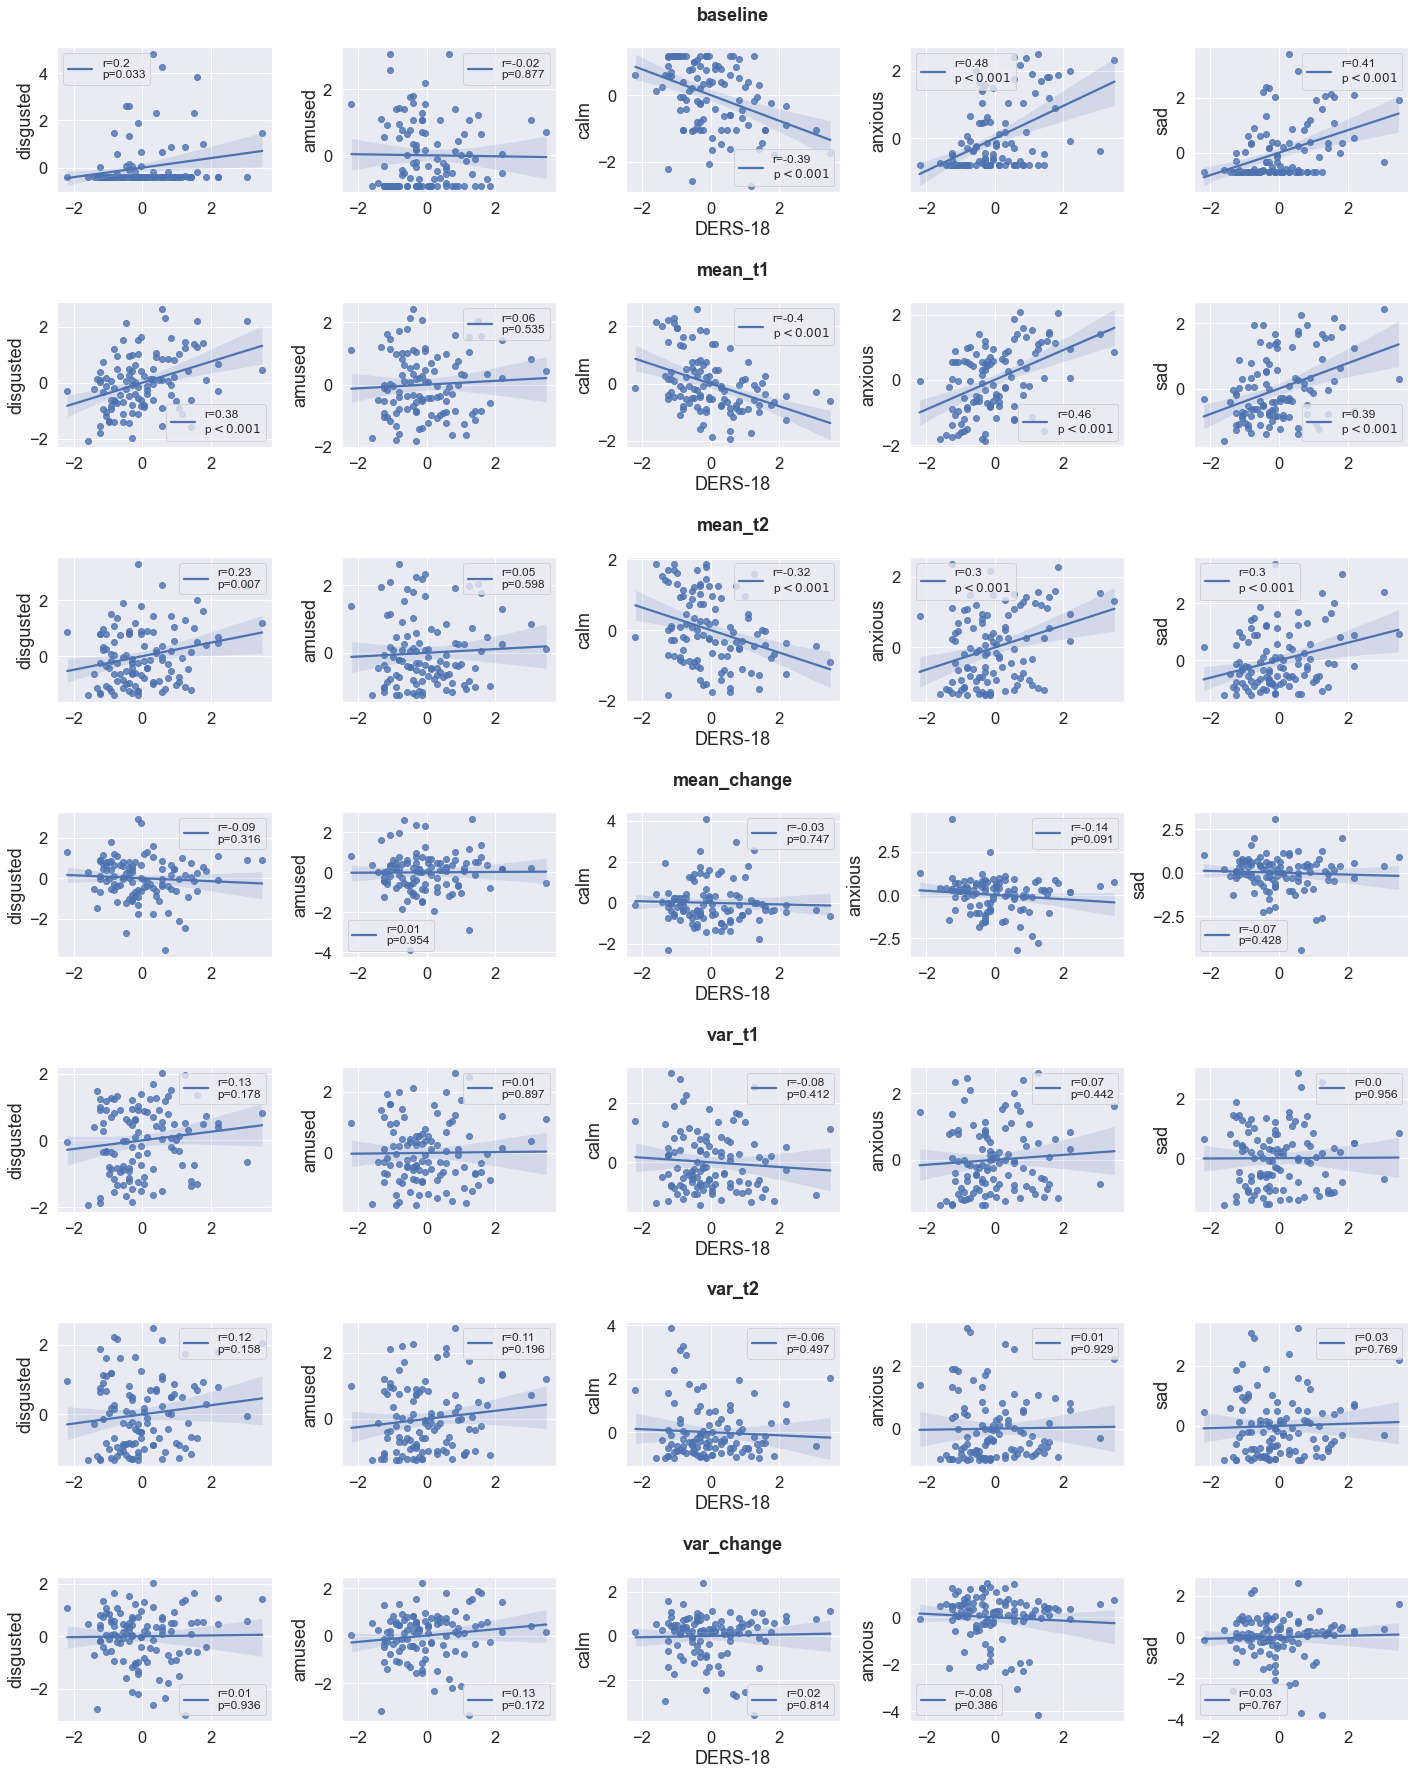

In [20]:
# Loop through the questionnaires and their corresponding z-scored data
for r, q in enumerate([i + '_zscore' for i in questionnaires]):
    # Create a new figure and a grid of subplots based on the number of timing conditions and mood categories
    fig, axs = plt.subplots(len(mood_dict), len(mood_categories), figsize=(20, 25))
    grid = plt.GridSpec(len(mood_dict), len(mood_categories))
    
    # Loop through each timing condition (baseline, mean_t1, mean_t2, etc.)
    for m, t in enumerate(mood_dict.keys()):
        # Find the mood-related column names for the current timing condition
        c = [i for i in df_mood.columns if t in i]
        
        # Loop through each mood-related column for the current timing condition
        for n, cc in enumerate(c):
            # Get the regression slope and p-value from the statistics DataFrame for the current questionnaire and timing condition
            slope = df_stats_all[r][(mood_categories[n], 'coef')].loc[q + ' -> ' + t]
            p_value = df_stats_all[r][(mood_categories[n], 'P>|z|')].loc[q + ' -> ' + t]
            
            # If the p-value is not already a string, format it as a string with three decimal places
            if not (type(p_value) == str):
                p_value = '=' + str(np.round(p_value, 3))
            
            # Create a regression plot for the current questionnaire and mood category
            b = sns.regplot(data=df_mood, x=q, y=cc, ax=axs[m, n], \
                            line_kws={'label': 'r=' + str(np.round(slope, 2)) + '\np' + p_value})
            
            # Add a legend to the plot with font size 12
            b.legend(prop={'size': 12})
            
            # Set x-axis and y-axis labels for the subplot
            if n == 2:
                b.set(xlabel=questionnaire_label[r])  # Set the x-axis label for the last row of subplots (timing labels)
            else:
                b.set(xlabel='')  # Remove the x-axis label for other rows of subplots
            
            b.set(ylabel=mood_categories[n])  # Set the y-axis label for each subplot (mood categories)
            
        # Uncomment the line below to add a subtitle above each set of subplots (commented in the original code).
        aux.create_subtitle(fig, grid[m, ::], list(mood_dict.keys())[m])
    
    # Adjust the layout of the subplots to avoid overlapping
    fig.tight_layout()

# If 'savefig' is True, save the figure as a PNG image in the specified 'filepath' and 'results/figures/' directory
if savefig:
    plt.savefig(filepath + '/results/figures/' + q + '_basics.png')


Change in mood ratings related to the subjective perception of successful compliance following the intervention:
--

In [21]:
# GLM predicting subjective perception of successful compliance following distancing based on mean rating change
for i in mood_categories:
    model = smf.glm('intervention_success ~ ' + i + '_mean_change', \
                    df_mood[df_mood['randomized_condition']==1], missing='drop').fit()
    display(pd.DataFrame(prep.convert_stats_table(model,1)).T)

,coef,std err,z,P>|z|,[0.025,0.975]
disgusted_mean_change,-0.3491,0.178,-1.96,0.05,-0.698,0.000041


,coef,std err,z,P>|z|,[0.025,0.975]
amused_mean_change,-0.0654,0.148,-0.443,0.658,-0.355,0.224


,coef,std err,z,P>|z|,[0.025,0.975]
calm_mean_change,0.3352,0.151,2.213,0.027,0.038,0.632


,coef,std err,z,P>|z|,[0.025,0.975]
anxious_mean_change,-0.3188,0.184,-1.737,0.082,-0.679,0.041


,coef,std err,z,P>|z|,[0.025,0.975]
sad_mean_change,-0.3617,0.171,-2.119,0.034,-0.696,-0.027


Reliability of emotion ratings in repeated video clips
--

In [22]:
# Read the list of videos used in the experiment from a CSV file and store it in a DataFrame.
df_finalVideoList = pd.read_csv('../experiment/public/prep/videosForExperiment.csv')

# Extract video clip IDs from the video path and store them in a list called 'videoclips'.
videopath = data[0]['datadoc']['video_path'].split(',')
videoclips = []
for i, j in enumerate(videopath):
    if i == len(videopath) - 1:
        videoclips.append(j[-11:-7])
    else:
        videoclips.append(j[-10:-6])

# Create a DataFrame 'df_videoclips' to store the video clip IDs.
df_videoclips = pd.DataFrame(videoclips)

# Find and store the duplicated video clip IDs in the 'duplicates' variable.
duplicates = df_videoclips[df_videoclips.duplicated()]

# Create a new DataFrame 'df_videoclips' to work with.
df_videoclips = pd.DataFrame(videoclips, columns=['videoclips'])

# Add two rows with NaN values at indices -1 and 53.5 in 'df_videoclips'.
df_videoclips.loc[-1] = np.nan
df_videoclips.loc[53.5] = np.nan

# Find and store the duplicated video clip IDs (after adding NaN values) in the 'duplicates' variable.
duplicates = pd.unique(df_videoclips['videoclips'][df_videoclips.duplicated()].dropna())

# Loop through the duplicated video clip IDs and compare 'df_videoclips' with each one (this is likely not the intended operation).
for i in duplicates:
    df_videoclips == i


In [23]:
# Import the required libraries
import pingouin as pg

# Create an empty DataFrame to store the results
df_results = pd.DataFrame()

# Initialize a list to store video categories for each duplicate video set
cat = []

# Loop over two sets of video duplicates (s = 0 or 1)
for s in range(2):
    for i in range(2):
        # Find the ith unique duplicate video set for the current video set (s+1)
        duplicate = np.unique(df_finalVideoList['videoset' + str(s + 1)][df_finalVideoList['videoset' + str(s + 1)].duplicated()])[i]
        
        # Extract the mood ratings for the current video set and duplicate
        B = mood_ratings_split[1:, i * 1, (df['randomized_videoset'] == s), 0][(df_finalVideoList['videoset' + str(s + 1)] == duplicate)]
        
        # Compute the correlation matrix for the mood ratings using pandas DataFrame
        correlation_matrix = pd.DataFrame(B).T.corr()
        print(correlation_matrix)
        
        # Reshape the DataFrame for intraclass correlation analysis
        Br = pd.melt(pd.DataFrame(B).T.reset_index(), id_vars='index', var_name='time', value_name='ratings')
        
        # Calculate the intraclass correlation coefficient (ICC) using pingouin
        icc = pg.intraclass_corr(data=Br, targets='index', raters='time', ratings='ratings')
        
        # Concatenate the ICC results for each duplicate to the 'df_results' DataFrame
        df_results = pd.concat((df_results, icc.iloc[1][2:]), axis=1)
        
        # Store the video category information for the current duplicate
        cat.append(df_finalVideoList['category'][df_finalVideoList['videoset' + str(s + 1)] == duplicate].values[0] + ' VS ' + str(s + 1))

# Transpose the 'df_results' DataFrame and set the video categories as the index
df_results = df_results.T
df_results.index = cat

# Rename the 'pval' column to 'pvalue'
df_results = df_results.rename(columns={"pval": "pvalue"})

# Replace p-values below 0.001 with the string '<$0.001'
df_results['pvalue'][df_results['pvalue'] < 0.001] = '$<$0.001'

# Display the results in the DataFrame
display(df_results)

# Additional code to export the results to LaTeX format (commented out)
# print(df_results.drop(columns='type').to_latex(escape=False))

          0         1         2
0  1.000000  0.541433  0.514912
1  0.541433  1.000000  0.827547
2  0.514912  0.827547  1.000000
          0         1         2
0  1.000000  0.747500  0.822783
1  0.747500  1.000000  0.810287
2  0.822783  0.810287  1.000000
          0         1         2
0  1.000000  0.723439  0.805511
1  0.723439  1.000000  0.906393
2  0.805511  0.906393  1.000000
          0         1         2
0  1.000000  0.594215  0.520378
1  0.594215  1.000000  0.755179
2  0.520378  0.755179  1.000000


,ICC,F,df1,df2,pvalue,CI95%
Disgust VS 1,0.589628,6.114938,59,118,$<$0.001,"[0.43, 0.72]"
Amusement VS 1,0.785332,12.433836,59,118,$<$0.001,"[0.69, 0.86]"
Amusement VS 2,0.795328,13.290052,47,94,$<$0.001,"[0.69, 0.87]"
Disgust VS 2,0.589719,5.588284,47,94,$<$0.001,"[0.43, 0.73]"


Baseline ratings changing before and after intervention
--

In [24]:
baseline_change = mood_ratings_split[0,:,:,1] - mood_ratings_split[0,:,:,0]
for i in range(5):
    print('mean = ' + str(np.round(np.nanmean(baseline_change[i,:]),3)), end=', ')
    print(scipy.stats.ttest_rel(mood_ratings_split[0,i,:,0], \
                                  mood_ratings_split[0,i,:,1]))

mean = 1.167, Ttest_relResult(statistic=-0.815503449066079, pvalue=0.41659579969309957)
mean = -8.287, Ttest_relResult(statistic=3.858971949985569, pvalue=0.0001950460249741587)
mean = -5.398, Ttest_relResult(statistic=2.319993296190753, pvalue=0.022238992445184087)
mean = 3.741, Ttest_relResult(statistic=-2.075383640581217, pvalue=0.04034867488468756)
mean = -2.741, Ttest_relResult(statistic=1.44077655239617, pvalue=0.15256773187662856)


In [25]:
for i in range(5):
    print(scipy.stats.ttest_ind(baseline_change[i,df['randomized_condition']==0], \
                                  baseline_change[i,df['randomized_condition']==1]))

Ttest_indResult(statistic=1.6130595444975995, pvalue=0.10970488882788963)
Ttest_indResult(statistic=-0.45916333825040173, pvalue=0.6470570892712134)
Ttest_indResult(statistic=0.12143944277057442, pvalue=0.903572891523164)
Ttest_indResult(statistic=0.09445678660450768, pvalue=0.9249246306667842)
Ttest_indResult(statistic=1.3584224023962097, pvalue=0.17721370850627385)


Participants seemed to be less amused, less calm and sadder in the second block. No differences in intervention group.